In [1]:
import csv
import os
import copy
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import pickle as pkl
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
import warnings
import pymc as pm
from pytensor import tensor as pt 
import arviz as az

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore')

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
gdp_regression_data_insample = pd.read_csv("../data/regression/cross_validation/gdp_regression_data_insample_festratified_0.csv")
countries_in_dataset = set(gdp_regression_data_insample.country)
years_in_dataset = set(gdp_regression_data_insample.year)
country_fe_cols = [col for col in gdp_regression_data_insample.columns if "country_fixed_effect" in col]
country_ie_cols = [col for col in gdp_regression_data_insample.columns if "incremental_effect" in col]
year_fe_cols = [col for col in gdp_regression_data_insample.columns if "year_fixed_effect" in col]
for country_fe in country_fe_cols:
    country = country_fe.split("_")[0]
    if country not in countries_in_dataset:
        gdp_regression_data_insample = gdp_regression_data_insample.drop(country_fe, axis=1)
        for i in range(1,4):
            gdp_regression_data_insample = gdp_regression_data_insample.drop(country + f"_incremental_effect_{i}", axis=1)
for year_fe in year_fe_cols:
    year = year_fe.split("_")[0]
    if int(year) not in years_in_dataset:
        gdp_regression_data_insample = gdp_regression_data_insample.drop(year_fe, axis=1)

In [3]:
model_spec = {
    "continuous_covariates" : [
        'precip_annual_std_[weight]',
        'precip_annual_std_[weight]_2',
        'precip_annual_std_[weight]_3',
        'temp_[weight]',
        'temp_[weight]_2', 
        'temp_[weight]_3'
    ],
    "discrete_covariates" : ['drought'],
    "fixed_effects" : ["year","country"],
    "incremental_effects" : 0,
    "weights" : "pop_weighted",
    "target" : "fd_ln_gdp"
}

# Add scaled continuous data

In [4]:
covar_scalers = []
for covar_col in model_spec["continuous_covariates"]:
    covar_scalers.append(StandardScaler())
    gdp_regression_data_insample[covar_col.replace("[weight]",model_spec["weights"])+"_scaled"] = covar_scalers[-1].fit_transform(np.array(gdp_regression_data_insample[covar_col.replace("[weight]",model_spec["weights"])]).reshape(-1,1)).flatten()
target_var_scaler = StandardScaler()
gdp_regression_data_insample[model_spec["target"]+"_scaled"] = target_var_scaler.fit_transform(np.array(gdp_regression_data_insample[model_spec["target"]]).reshape(-1,1)).flatten()

In [5]:
target_data = gdp_regression_data_insample[model_spec["target"]+"_scaled"]
model_variables = []
for covar in model_spec["continuous_covariates"]:
    model_variables.append(covar.replace("[weight]",model_spec["weights"])+"_scaled")
for covar in model_spec["discrete_covariates"]:
    model_variables.append(covar)
for fe in model_spec["fixed_effects"]:
    for fe_col in [col for col in gdp_regression_data_insample.columns if col.endswith(f"{fe}_fixed_effect")]:
        model_variables.append(fe_col)
for i in range(model_spec["incremental_effects"]):
    for ie_col in [col for col in gdp_regression_data_insample.columns if col.endswith(f"incremental_effect_{i+1}")]:
        model_variables.append(ie_col)
model_data = gdp_regression_data_insample[model_variables]

# Fixed-effects Bayesian model

In [11]:
first_year_fe_col = [col for col in model_data.columns if "year_fixed_effect" in col][0]

model_data_first_fe_removed = copy.deepcopy(model_data)
model_data_first_fe_removed[first_year_fe_col] = 0

with pm.Model() as pymc_model:

    model_variable_coefs = pm.Normal("model_variable_coefs", 0, 10, shape=(len(model_data_first_fe_removed.columns)))
    model_terms = pm.Deterministic("model_variable_terms", pt.sum(model_variable_coefs * model_data_first_fe_removed, axis=1))

    gdp_std_scale = pm.HalfNormal("gdp_std_scale", 5)
    gdp_std = pm.HalfNormal("gdp_std", sigma=gdp_std_scale)
    gdp_posterior = pm.Normal('gdp_posterior', mu=model_terms, sigma=gdp_std, observed=target_data)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(target_accept=.99, cores=4)
    posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [gdp_posterior, gdp_std, gdp_std_scale, model_variable_coefs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [model_variable_coefs, gdp_std_scale, gdp_std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4644 seconds.
Sampling: [gdp_posterior]


In [32]:
# with open ('../output/models/bayes_models/fixed_effects_model.pkl', 'wb') as buff:
#     pkl.dump({
#         "prior":prior,
#         "trace":trace,
#         "posterior":posterior,
#         "var_list":(model_data.columns),
#         "model_spec":model_spec
#     },buff)

In [22]:
fixed_effects_model = pd.read_pickle('../output/models/bayes_models/fixed_effects_model.pkl')
posterior = fixed_effects_model["posterior"]
var_list = fixed_effects_model["var_list"]

In [16]:
az.summary(trace, var_names=["model_variable_coefs"])[0:10]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
model_variable_coefs[0],-0.061,0.090,-0.225,0.108,0.002,0.002,1762.0,2355.0,1.0
model_variable_coefs[1],0.118,0.183,-0.232,0.438,0.004,0.003,1716.0,2099.0,1.0
model_variable_coefs[2],-0.033,0.102,-0.212,0.166,0.002,0.002,1751.0,2121.0,1.0
model_variable_coefs[3],0.292,0.136,0.052,0.562,0.003,0.002,1707.0,1950.0,1.0
model_variable_coefs[4],-0.818,0.325,-1.420,-0.212,0.008,0.006,1666.0,2254.0,1.0
model_variable_coefs[5],0.492,0.200,0.119,0.862,0.005,0.003,1671.0,2120.0,1.0
model_variable_coefs[6],-0.033,0.039,-0.105,0.042,0.001,0.001,4920.0,3276.0,1.0
model_variable_coefs[7],0.119,9.970,-18.845,18.811,0.138,0.167,5236.0,2838.0,1.0
model_variable_coefs[8],-0.102,0.102,-0.279,0.101,0.001,0.001,5590.0,2810.0,1.0
model_variable_coefs[9],0.023,0.102,-0.164,0.219,0.001,0.002,4862.0,2624.0,1.0


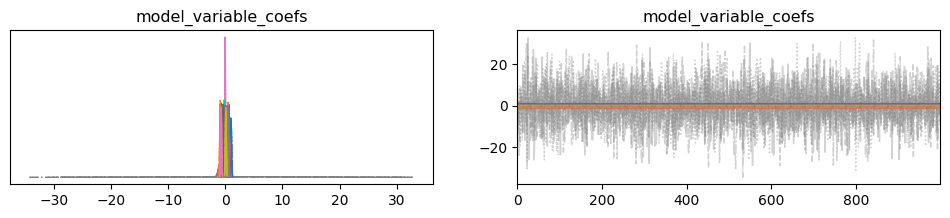

In [18]:
fig = az.plot_trace(trace, var_names=["model_variable_coefs"]).ravel()[0].figure
fig.show()

## Unscale

In [23]:
gdp_regression_data_insample = pd.read_csv(f"../data/regression/cross_validation/gdp_regression_data_insample_festratified_0.csv")
scaled_vars = {}
unscaled_vars = {}
for index, var in enumerate(list(model_data.columns)):
    scaled_vars[var] = posterior.posterior.model_variable_coefs[:,:,index].data.flatten()
for var, samples in scaled_vars.items():
    # TODO: Note this is not exactly correct in the case of ^2 and ^3 vars
    if var in model_data.columns[0:6]:
        if "_scaled" in var:
            var = var.replace("_scaled","")
        unscaled_vars[var] = np.array(samples) * np.std(gdp_regression_data_insample.fd_ln_gdp) / np.std(gdp_regression_data_insample[var])
    else:
        unscaled_vars[var] = np.array(samples) * np.std(gdp_regression_data_insample.fd_ln_gdp)

## Predict

In [24]:
gdp_regression_data_outsample = pd.read_csv("../data/regression/cross_validation/gdp_regression_data_outsample_festratified_0.csv")
bayes_mse, bayes_pred_int_acc, prediction_in_range = [], [], []
for row in gdp_regression_data_outsample.iterrows():
    row = row[1]
    prediction = []
    for var in list(model_data.columns):
        if "_scaled" in var:
            var = var.replace("_scaled","")
        prediction.append(unscaled_vars[var] * getattr(row, var))
    prediction = np.sum(prediction, axis=0)
    bayes_mse.append(np.mean(np.square(np.array(np.mean(prediction, axis=0)) - row.fd_ln_gdp)))

    interval = np.quantile(prediction,[.025,.975])
    if row.fd_ln_gdp >= interval[0] and row.fd_ln_gdp <= interval[1]:
        prediction_in_range.append(1)
    else:
        prediction_in_range.append(0)

print(np.mean(bayes_mse))
print(np.mean(np.mean(prediction_in_range)))

0.019026967239976933
0.31014150943396224


# Random-intercept Bayesian model

In [88]:
first_year_fe_col = [col for col in model_data.columns if "year_fixed_effect" in col][0]

model_data_first_fe_removed = copy.deepcopy(model_data)
model_data_first_fe_removed[first_year_fe_col] = 0

non_fe_vars = [col for col in model_data_first_fe_removed.columns if "year_fixed_effect" not in col and "country_fixed_effect" not in col]
year_fe_vars = [col for col in model_data_first_fe_removed.columns if "year_fixed_effect" in col]

with pm.Model() as pymc_model:

    non_fe_coefs = pm.Normal("model_variable_coefs", 0, 10, shape=(len(non_fe_vars)))
    non_fe_terms = pm.Deterministic("model_variable_terms", pt.sum(non_fe_coefs * model_data_first_fe_removed[non_fe_vars], axis=1))

    global_year_re_mean = pm.Normal("global_year_re_mean",0,10)
    global_year_re_sd = pm.HalfNormal("global_year_re_sd",5)
    year_re_means = pm.Normal("year_re_means", global_year_re_mean, global_year_re_sd, shape=len(year_fe_vars))
    year_re_sd = pm.HalfNormal("year_re_sd", 5)
    year_re_coefs = pm.Normal("year_re_coefs", year_re_means, year_re_sd, shape=len(year_fe_vars))
    year_re_terms = pm.Deterministic("year_re_terms", pt.sum(year_re_coefs * model_data_first_fe_removed[year_fe_vars], axis=1))

    gdp_prior = pm.Deterministic(
        "gdp_prior",
        non_fe_terms +
        country_re_terms +
        year_re_terms
    )
    
    gdp_std_scale = pm.HalfNormal("gdp_std_scale", 5)
    gdp_std = pm.HalfNormal("gdp_std", sigma=gdp_std_scale)
    gdp_posterior = pm.Normal('gdp_posterior', mu=gdp_prior, sigma=gdp_std, observed=target_data)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(target_accept=.99, cores=4)
    posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [country_re_coefs, country_re_means, country_re_sd, gdp_posterior, gdp_std, gdp_std_scale, global_country_re_mean, global_country_re_sd, global_year_re_mean, global_year_re_sd, model_variable_coefs, year_re_coefs, year_re_means, year_re_sd]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [model_variable_coefs, global_country_re_mean, global_country_re_sd, country_re_means, country_re_sd, country_re_coefs, global_year_re_mean, global_year_re_sd, year_re_means, year_re_sd, year_re_coefs, gdp_std_scale, gdp_std]


ValueError: Not enough samples to build a trace.

In [ ]:
# with open ('../output/models/bayes_models/random_intercept_model.pkl', 'wb') as buff:
#     pkl.dump({
#         "prior":prior,
#         "trace":trace,
#         "posterior":posterior,
#         "var_list":(model_data.columns),
#         "model_spec":model_spec
#     },buff)

In [19]:
random_intercept_model = pd.read_pickle('../output/models/bayes_models/random_intercept_model.pkl')
posterior = random_intercept_model["posterior"]
var_list = random_intercept_model["var_list"]
model_spec = random_intercept_model["model_spec"]

## Unscale

In [20]:
gdp_regression_data_insample = pd.read_csv(f"../data/regression/cross_validation/gdp_regression_data_insample_festratified_0.csv")
scaled_vars = {}
unscaled_vars = {}
for index, var in enumerate(var_list[0:7]):
    scaled_vars[var] = posterior.posterior.model_variable_coefs[:,:,index].data.flatten()
for index, var in enumerate(var_list[7:]):
    scaled_vars[var] = posterior.posterior.year_re_coefs[:,:,index].data.flatten()
for var, samples in scaled_vars.items():
    # TODO: Note this is not exactly correct in the case of ^2 and ^3 vars
    if var in var_list[0:6]:
        if "_scaled" in var:
            var = var.replace("_scaled","")
        unscaled_vars[var] = np.array(samples) * np.std(gdp_regression_data_insample.fd_ln_gdp) / np.std(gdp_regression_data_insample[var])
    else:
        unscaled_vars[var] = np.array(samples) * np.std(gdp_regression_data_insample.fd_ln_gdp)

## Predict

In [21]:
gdp_regression_data_outsample = pd.read_csv("../data/regression/cross_validation/gdp_regression_data_outsample_festratified_0.csv")
bayes_mse, bayes_pred_int_acc, prediction_in_range = [], [], []
for row in gdp_regression_data_outsample.iterrows():
    row = row[1]
    prediction = []
    for var in list(model_data.columns):
        if "_scaled" in var:
            var = var.replace("_scaled","")
        prediction.append(unscaled_vars[var] * getattr(row, var))
    prediction = np.sum(prediction, axis=0)
    bayes_mse.append(np.mean(np.square(np.array(np.mean(prediction, axis=0)) - row.fd_ln_gdp)))

    interval = np.quantile(prediction,[.025,.975])
    if row.fd_ln_gdp >= interval[0] and row.fd_ln_gdp <= interval[1]:
        prediction_in_range.append(1)
    else:
        prediction_in_range.append(0)

print(np.mean(bayes_mse))
print(np.mean(np.mean(prediction_in_range)))

0.019025102210332174
0.30306603773584906


# Random year intercept and Random country slope Bayesian model
## Random slopes for Drought only

In [ ]:
first_year_fe_col = [col for col in model_data.columns if "year_fixed_effect" in col][0]

model_data_first_fe_removed = copy.deepcopy(model_data)
model_data_first_fe_removed[first_year_fe_col] = 0

vars_to_bundle = [col for col in model_data_first_fe_removed.columns if "country_fixed_effect" not in col and "incremental_effect" not in col and col != "drought"]
year_fe_vars = [col for col in model_data_first_fe_removed.columns if "year_fixed_effect" in col]
country_fe_vars = [col for col in model_data_first_fe_removed.columns if "country_fixed_effect" in col]

with pm.Model() as pymc_model:
    
    global_country_rs_mean = pm.Normal("global_country_rs_mean",0,10)
    global_country_rs_sd = pm.HalfNormal("global_country_rs_sd",5)
    country_rs_means = pm.Normal("country_rs_means", global_country_rs_mean, global_country_rs_sd, shape=(1,len(country_fe_vars)))
    country_rs_sd = pm.HalfNormal("country_rs_sd", 5)
    country_rs_coefs = pm.Normal("country_rs_coefs", country_rs_means, country_rs_sd)
    country_rs_matrix = pm.Deterministic("country_rs_matrix", pt.sum(country_rs_coefs * model_data[country_fe_vars],axis=1))

    drought_terms = pm.Deterministic("drought_terms", country_rs_matrix * model_data_first_fe_removed["drought"])

    covar_coefficients = pm.Normal("model_variable_coefs", 0, 10, shape=len(vars_to_bundle))
    covar_terms = pm.Deterministic("model_variable_terms", pt.sum(covar_coefficients * model_data_first_fe_removed[vars_to_bundle], axis=1))
    
    gdp_prior = pm.Deterministic(
        "gdp_prior",
        covar_terms +
          drought_terms
    )
    
    gdp_std_scale = pm.HalfNormal("gdp_std_scale", 5)
    gdp_std = pm.HalfNormal("gdp_std", sigma=gdp_std_scale)
    gdp_posterior = pm.Normal('gdp_posterior', mu=gdp_prior, sigma=gdp_std, observed=target_data)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(target_accept=.99, cores=4)
    posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [country_rs_coefs, country_rs_means, country_rs_sd, gdp_posterior, gdp_std, gdp_std_scale, global_country_rs_mean, global_country_rs_sd, model_variable_coefs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_country_rs_mean, global_country_rs_sd, country_rs_means, country_rs_sd, country_rs_coefs, model_variable_coefs, gdp_std_scale, gdp_std]


In [ ]:
with open ('../output/models/bayes_models/random_year_intercept_random_country_drought_slope_model.pkl', 'wb') as buff:
    pkl.dump({
        "prior":prior,
        "trace":trace,
        "posterior":posterior,
        "var_list":(model_data.columns),
        "model_spec":model_spec
    },buff)

## Unscale

In [15]:
gdp_regression_data_insample = pd.read_csv(f"../data/regression/cross_validation/gdp_regression_data_insample_festratified_0.csv")
gdp_regression_data_outsample = pd.read_csv(f"../data/regression/cross_validation/gdp_regression_data_outsample_festratified_0.csv")
scaled_vars = {}
unscaled_vars = {}
for index, var in enumerate(list(model_data.columns[0:7])):
    scaled_vars[var] = posterior.posterior.covar_coefficients[:,:,index].data.flatten()
for var, samples in scaled_vars.items():
    # TODO: Note this is not exactly correct in the case of ^2 and ^3 vars
    if var in model_data.columns[0:6]:
        if "_scaled" in var:
            var = var.replace("_scaled","")
        unscaled_vars[var] = np.array(samples) * np.std(gdp_regression_data_insample.fd_ln_gdp) / np.std(gdp_regression_data_insample[var])
    else:
        unscaled_vars[var] = np.array(samples) * np.std(gdp_regression_data_insample.fd_ln_gdp)

## Predict

In [17]:
gdp_regression_data_outsample = pd.read_csv("../data/regression/cross_validation/gdp_regression_data_outsample_festratified_0.csv")
bayes_mse, bayes_pred_int_acc, prediction_in_range = [], [], []
for row in gdp_regression_data_outsample.iterrows():
    row = row[1]
    prediction = []
    for var in list(model_data.columns[0:7]):
        if "_scaled" in var:
            var = var.replace("_scaled","")
        prediction.append(unscaled_vars[var] * getattr(row, var))
    prediction = np.sum(prediction, axis=0)
    bayes_mse.append(np.mean(np.square(np.array(np.mean(prediction, axis=0)) - row.fd_ln_gdp)))

    interval = np.quantile(prediction,[.025,.975])
    if row.fd_ln_gdp >= interval[0] and row.fd_ln_gdp <= interval[1]:
        prediction_in_range.append(1)
    else:
        prediction_in_range.append(0)

print(np.mean(bayes_mse))
print(np.mean(np.mean(prediction_in_range)))

0.3438734052598581
0.9941037735849056
